In [1]:
# importing necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model, regularizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
import os
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image

from sklearn.model_selection import train_test_split

#import tensorflow.keras.backend as K
# clear the keras session
#K.clear_session()

C:\Users\kpegg\AppData\Local\Temp\ipykernel_27480\2281955899.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\kpegg\AppData\Local\Temp\ipykernel_27480\2281955899.py:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
train = "../data/dog-breed-identification/train"
test = "../data/dog-breed-identification/test"
df=pd.read_csv("../data/dog-breed-identification/labels.csv")
df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [3]:
labels = df["breed"].unique().tolist()

In [4]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")

In [5]:
# converting images to numpy array
image_size = 100  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array with preprocessing
    img_array = np.array(img)/255
    
    # Convert to array and preprocess
    #img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array

In [6]:
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

In [7]:
X = train_data
y = label_data

# # split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

In [8]:
model3 = Sequential()

# Add Convolutional layers with dropout
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), 
                  #kernel_regularizer=regularizers.l2(0.01)
                  ))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.25))  # Add dropout after the first convolutional layer

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(120, activation='softmax'))  # Assuming 120 output classes

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
third = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
128/128 [==============================] - 49s 385ms/step - loss: 0.1376 - accuracy: 0.9627 - val_loss: 20.2083 - val_accuracy: 0.0494
Epoch 2/30
128/128 [==============================] - 63s 493ms/step - loss: 0.1053 - accuracy: 0.9702 - val_loss: 20.3855 - val_accuracy: 0.0484
Epoch 3/30
128/128 [==============================] - 52s 409ms/step - loss: 0.0867 - accuracy: 0.9763 - val_loss: 21.9345 - val_accuracy: 0.0494
Epoch 4/30
128/128 [==============================] - 50s 390ms/step - loss: 0.0914 - accuracy: 0.9740 - val_loss: 21.7522 - val_accuracy: 0.0513
Epoch 5/30
128/128 [==============================] - 50s 389ms/step - loss: 0.0786 - accuracy: 0.9770 - val_loss: 22.7660 - val_accuracy: 0.0479
Epoch 6/30
128/128 [==============================] - 51s 395ms/step - loss: 0.1577 - accuracy: 0.9563 - val_loss: 21.4033 - val_accuracy: 0.0474
Epoch 7/30
128/128 [==============================] - 50s 388ms/step - loss: 0.1300 - accuracy: 0.9656 - val_loss: 22.0039 -

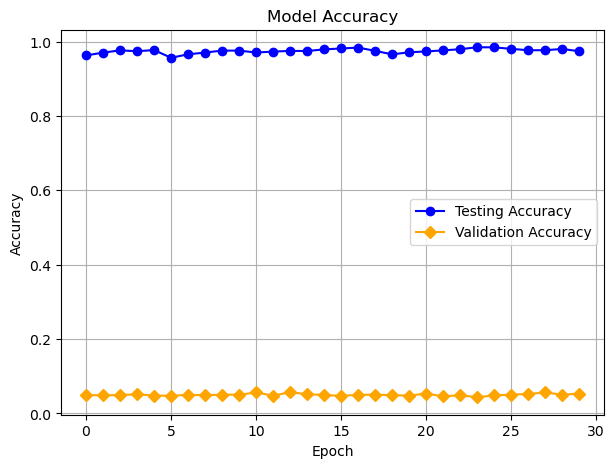

In [18]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(third.history['accuracy'],label="Testing Accuracy",color="blue",marker="o")
plt.plot(third.history['val_accuracy'],label="Validation Accuracy",color="orange",marker="D")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Function to preprocess an image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load the 'labels' dataframe
df_labels = pd.read_csv("../data/dog-breed-identification/labels.csv")

# Predict on test images and map predicted class indices to breed names
predicted_breeds = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = model3.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_breeds.append(predicted_breed)

# Print the predicted breed for each image
for image_filename, predicted_breed in zip(os.listdir(test), predicted_breeds):
    print(f"Image: {image_filename}, Predicted Breed: {predicted_breed}")

1/1 [==============================] - 0s 43ms/step
Image: 000621fb3cbb32d8935728e48679680e.jpg, Predicted Breed: giant_schnauzer
Image: 00102ee9d8eb90812350685311fe5890.jpg, Predicted Breed: brittany_spaniel
Image: 0012a730dfa437f5f3613fb75efcd4ce.jpg, Predicted Breed: irish_setter
Image: 001510bc8570bbeee98c8d80c8a95ec1.jpg, Predicted Breed: kuvasz
Image: 001a5f3114548acdefa3d4da05474c2e.jpg, Predicted Breed: samoyed
Image: 00225dcd3e4d2410dd53239f95c0352f.jpg, Predicted Breed: walker_hound
Image: 002c2a3117c2193b4d26400ce431eebd.jpg, Predicted Breed: norfolk_terrier
Image: 002c58d413a521ae8d1a5daeb35fc803.jpg, Predicted Breed: lakeland_terrier
Image: 002f80396f1e3db687c5932d7978b196.jpg, Predicted Breed: golden_retriever
Image: 0036c6bcec6031be9e62a257b1c3c442.jpg, Predicted Breed: australian_terrier
Image: 0041940322116ae58c38130f5a6f71f9.jpg, Predicted Breed: bluetick
Image: 0042d6bf3e5f3700865886db32689436.jpg, Predicted Breed: malinois
Image: 004476c96f575879af4af471af65cae8.jpg

1/1 [==============================] - 0s 34ms/step


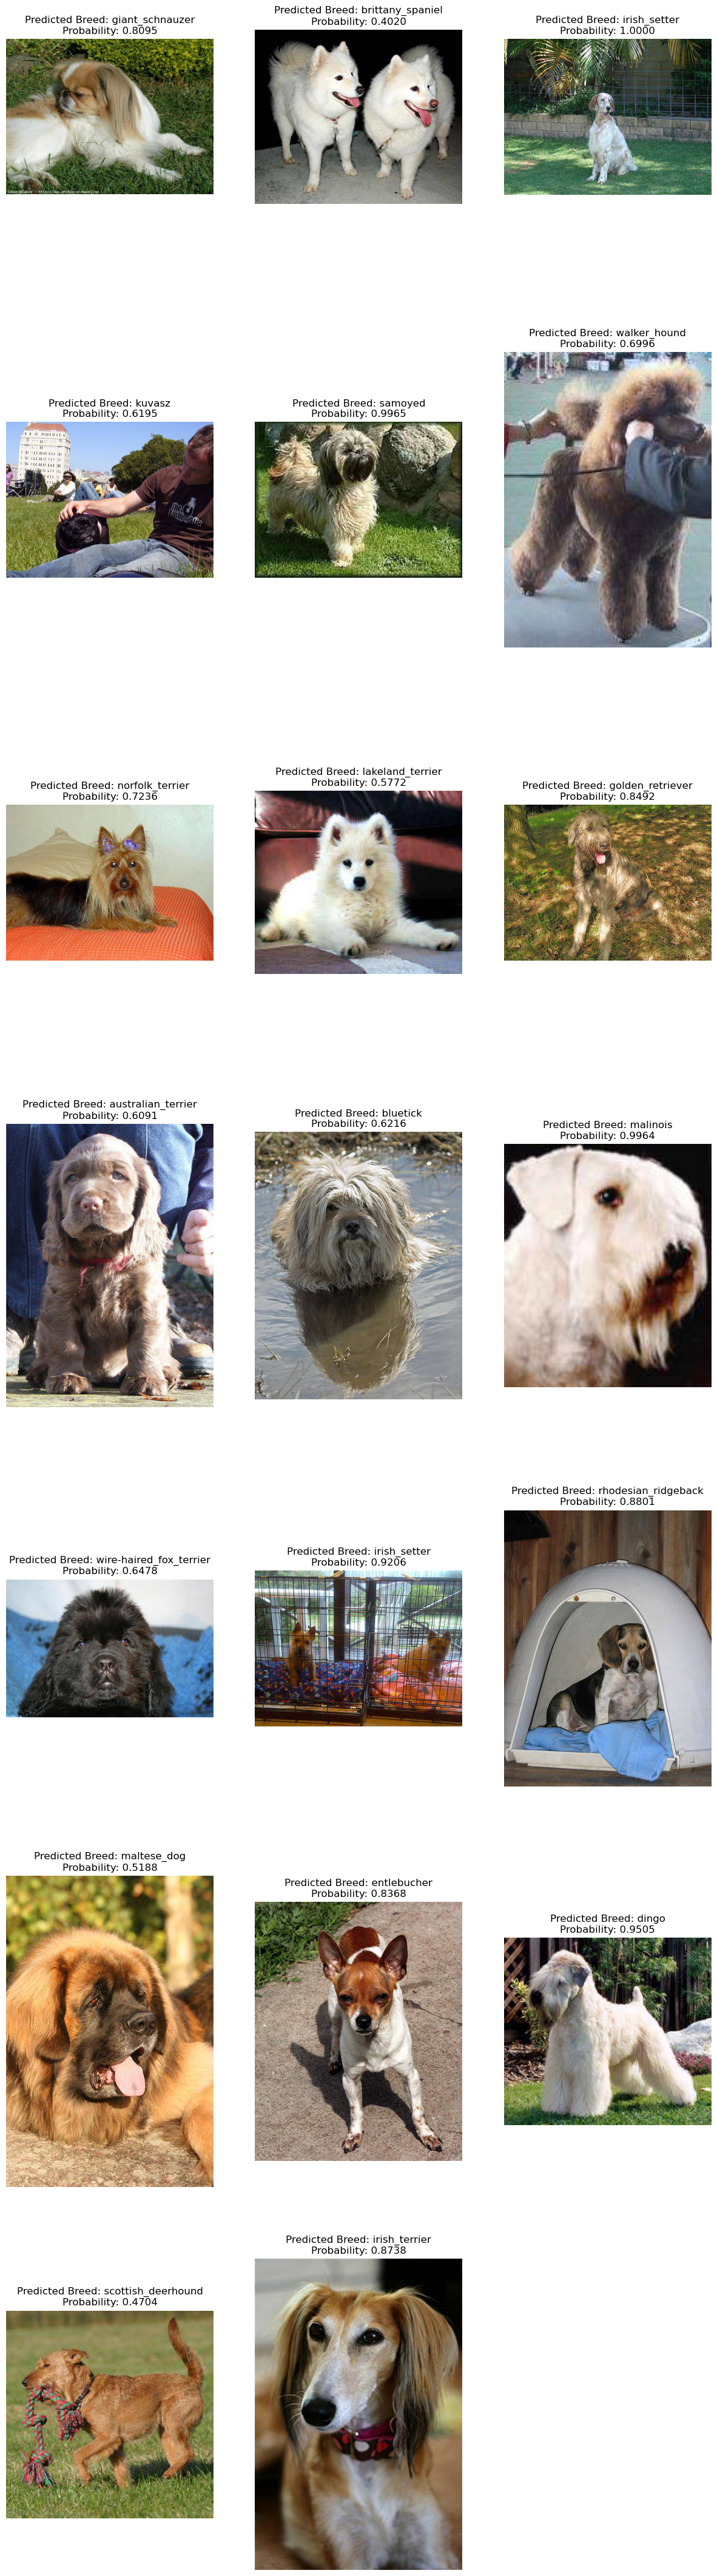

In [11]:
# Predict on test images and map predicted class indices to breed names
predicted_breeds = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = model3.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_probability = np.max(predictions)
    predicted_breeds.append((image_filename, predicted_breed, predicted_probability))

# Display images along with predicted breed
num_images_to_display = 20  # Change this to display more or fewer images
num_rows = (num_images_to_display + 3 - 1) // 3

plt.figure(figsize=(15, 8 * num_rows))
for i, (image_filename, predicted_breed, predicted_probability) in enumerate(predicted_breeds[:num_images_to_display]):
    image_path = os.path.join(test, image_filename)
    img = Image.open(image_path)

    row = i // 3
    col = i % 3

    plt.subplot(num_rows, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.4f}")
    plt.axis("off")

1/1 [==============================] - 0s 61ms/step


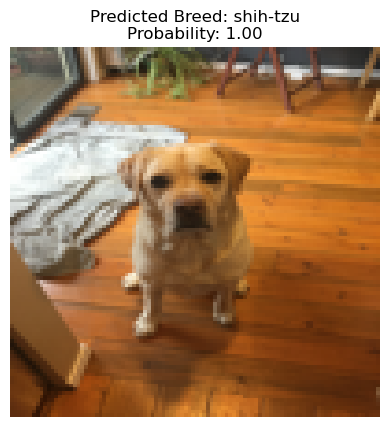

In [15]:
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) #/ 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path of the image to be predicted
image_path = r"C:\Users\kpegg\Documents\Flatiron\Projects\05_Nose_Knows\data\IMG_6753.jpg"

# Preprocess the image
preprocessed_img = preprocess_image(image_path, 100)  # Assuming image size is 100x100

# Rotate the image
img_rotated = Image.open(image_path).rotate(270, expand=True)
img_rotated = img_rotated.resize((100, 100))  # Resize after rotation

# Preprocess the rotated image
preprocessed_rotated_img = np.array(img_rotated) #/ 255.0  # Normalize pixel values
preprocessed_rotated_img = np.expand_dims(preprocessed_rotated_img, axis=0)  # Add batch dimension

# Use the pre-trained model to predict the breed
predictions = model3.predict(preprocessed_rotated_img)
predicted_class_index = np.argmax(predictions)
predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img_rotated)
plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()

In [21]:
model4 = Sequential()

# Add Convolutional layers with dropout
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))  # Add dropout after the first convolutional layer

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(120, activation='softmax'))  # Assuming 120 output classes

# Compile the model
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
fourth = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
128/128 [==============================] - 43s 332ms/step - loss: 4.8141 - accuracy: 0.0095 - val_loss: 4.7724 - val_accuracy: 0.0186
Epoch 2/30
128/128 [==============================] - 53s 414ms/step - loss: 4.6147 - accuracy: 0.0270 - val_loss: 4.5369 - val_accuracy: 0.0367
Epoch 3/30
128/128 [==============================] - 51s 398ms/step - loss: 4.3314 - accuracy: 0.0519 - val_loss: 4.3973 - val_accuracy: 0.0406
Epoch 4/30
128/128 [==============================] - 52s 407ms/step - loss: 4.1380 - accuracy: 0.0823 - val_loss: 4.3530 - val_accuracy: 0.0528
Epoch 5/30
128/128 [==============================] - 51s 399ms/step - loss: 3.9443 - accuracy: 0.1113 - val_loss: 4.4135 - val_accuracy: 0.0543
Epoch 6/30
128/128 [==============================] - 55s 427ms/step - loss: 3.6990 - accuracy: 0.1455 - val_loss: 4.4696 - val_accuracy: 0.0670
Epoch 7/30
128/128 [==============================] - 52s 409ms/step - loss: 3.3942 - accuracy: 0.1985 - val_loss: 4.6736 - val_ac

Accuracy went down, less overfit, validation accuracy still low

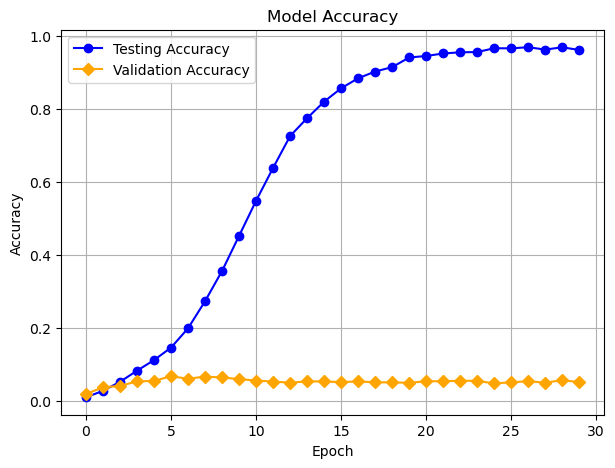

In [23]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(fourth.history['accuracy'],label="Testing Accuracy",color="blue",marker="o")
plt.plot(fourth.history['val_accuracy'],label="Validation Accuracy",color="orange",marker="D")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [24]:
model5 = Sequential()

# Add Convolutional layers with dropout
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.25))  # Add dropout after the first convolutional layer

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
model5.add(Flatten())
model5.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
model5.add(Dense(128, activation='relu'))
model5.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
fifth = model5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
128/128 [==============================] - 54s 410ms/step - loss: 4.8139 - accuracy: 0.0092 - val_loss: 4.7935 - val_accuracy: 0.0093
Epoch 2/30
128/128 [==============================] - 52s 405ms/step - loss: 4.7070 - accuracy: 0.0181 - val_loss: 4.6174 - val_accuracy: 0.0196
Epoch 3/30
128/128 [==============================] - 52s 406ms/step - loss: 4.5391 - accuracy: 0.0284 - val_loss: 4.5024 - val_accuracy: 0.0333
Epoch 4/30
128/128 [==============================] - 52s 405ms/step - loss: 4.3622 - accuracy: 0.0463 - val_loss: 4.3890 - val_accuracy: 0.0416
Epoch 5/30
128/128 [==============================] - 52s 405ms/step - loss: 4.1878 - accuracy: 0.0654 - val_loss: 4.3510 - val_accuracy: 0.0455
Epoch 6/30
128/128 [==============================] - 52s 406ms/step - loss: 4.0154 - accuracy: 0.0932 - val_loss: 4.3143 - val_accuracy: 0.0543
Epoch 7/30
128/128 [==============================] - 52s 406ms/step - loss: 3.8265 - accuracy: 0.1202 - val_loss: 4.3858 - val_ac

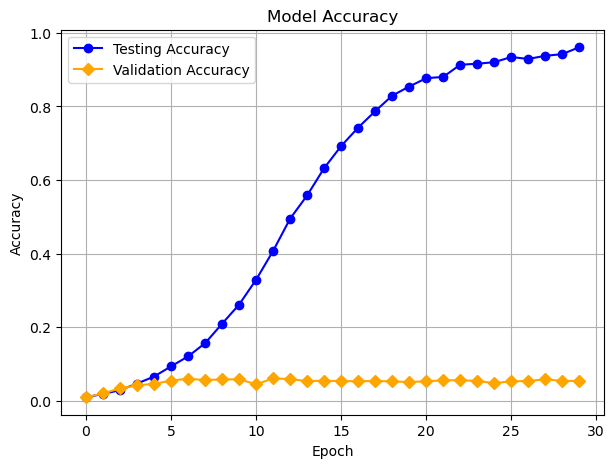

In [26]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(fifth.history['accuracy'],label="Testing Accuracy",color="blue",marker="o")
plt.plot(fifth.history['val_accuracy'],label="Validation Accuracy",color="orange",marker="D")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

1/1 [==============================] - 0s 69ms/step


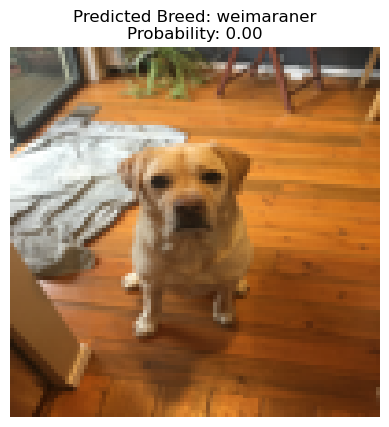

In [27]:
# Preprocess the image
preprocessed_img2 = preprocess_image(image_path, 100)  # Assuming image size is 100x100

# Rotate the image
img_rotated2 = Image.open(image_path).rotate(270, expand=True)
img_rotated2 = img_rotated2.resize((100, 100))  # Resize after rotation

# Preprocess the rotated image
preprocessed_rotated_img2 = np.array(img_rotated2) 
preprocessed_rotated_img2 = np.expand_dims(preprocessed_rotated_img2, axis=0)  # Add batch dimension

# Use the pre-trained model to predict the breed
predictions5 = model5.predict(preprocessed_rotated_img2)
predicted_class_index = np.argmax(predictions5)
predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img_rotated2)
plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()